## Setup & Helpers

In [1]:
# Setup & helpers (works for Parquet or CSV partitions)
import os, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.inspection import permutation_importance
from IPython.display import display
import joblib

# Auto-detect BASE_DIR relative to this notebook's working dir
BASE_DIR = None
for cand in [Path("data/clinical_synth_v1"),
             Path("../data/clinical_synth_v1"),
             Path("../../data/clinical_synth_v1")]:
    if cand.exists():
        BASE_DIR = str(cand)
        break
if BASE_DIR is None:
    raise FileNotFoundError("Could not find 'data/clinical_synth_v1' under ., .., or ../.. — set BASE_DIR manually.")

DATASET_P3 = "patient_year_part3_nb"  # labels + slice columns
DATASET_P4 = "patient_year_part4_nb"  # engineered features (+ labels)
ART_PATH   = str(Path(BASE_DIR) / "artifacts_v1" / "t2d_hgb_model_v1.joblib")

print("BASE_DIR →", BASE_DIR)
print("ART exists →", Path(ART_PATH).exists())

def read_partition_auto(base_dir, year):
    """Read year partition (prefer Parquet, fallback to CSV)."""
    base_dir = Path(base_dir)
    p = base_dir / f"year={year}"
    pq = p / "part-0.parquet"
    cs = p / "part-0.csv"
    if pq.exists(): return pd.read_parquet(pq)
    if cs.exists(): return pd.read_csv(cs)
    raise FileNotFoundError(f"Missing partition for year={year} under {p}")

def list_years(base_dir):
    base = Path(base_dir)
    ys = [int(d.name.split("=")[1]) for d in base.iterdir() if d.is_dir() and d.name.startswith("year=")]
    ys.sort()
    return ys

# --- Compatibility aliases so later cells work as-is ---
def read_partition(base_dir, year):
    """Thin alias so later cells that expect `read_partition` keep working."""
    return read_partition_auto(base_dir, year)

# (list_years already exists with the expected name)



BASE_DIR → ../data/clinical_synth_v1
ART exists → True


## Sanity checks: counts, lag(obs–true), missingness, prevalence by slices

In [2]:
# Load Part 3 (for labels and slice columns), Part 4 (for engineered features)
in_base_p3 = os.path.join(BASE_DIR, DATASET_P3)
in_base_p4 = os.path.join(BASE_DIR, DATASET_P4)

years = list_years(in_base_p3)
df_p3 = (pd.concat([read_partition(in_base_p3, y) for y in years], ignore_index=True)
           .sort_values(["patient_id","year"])
           .reset_index(drop=True))

print("Rows:", len(df_p3), "| Patients:", df_p3["patient_id"].nunique(), "| Years:", (years[0], years[-1]))
print("\nObserved positives per year:\n", df_p3.groupby("year")["label_observed"].sum())
print("\nTrue positives per year:\n", df_p3.groupby("year")["label_true"].sum())

# Lag between observed and true diagnosis years (obs - true)
true_year = (df_p3.loc[df_p3["label_true"]==1, ["patient_id","year"]]
             .drop_duplicates().set_index("patient_id")["year"])
obs_year  = (df_p3.loc[df_p3["label_observed"]==1, ["patient_id","year"]]
             .drop_duplicates().set_index("patient_id")["year"])
lag_df = pd.DataFrame({"true": true_year, "obs": obs_year}).dropna()
lag_df["lag"] = lag_df["obs"] - lag_df["true"]
print("\nLag distribution (obs - true):")
print(lag_df["lag"].value_counts(dropna=False).sort_index())

# Missingness (on engineered numeric features from Part 4)
df_p4 = pd.concat([read_partition(in_base_p4, y) for y in years], ignore_index=True)
num_cols = df_p4.select_dtypes(include=[np.number]).columns.tolist()
miss_rate = df_p4[num_cols].isna().mean().sort_values(ascending=False)
print("\nTop-10 numeric missingness rates (Part 4):")
print((miss_rate.head(10)*100).round(1).astype(str) + "%")

# Prevalence by slices on last year (observed)
val_year = years[-1]
mask_val = (df_p3["year"] == val_year)
print(f"\nPrevalence in {val_year} by slices (observed):")
for col in ["sex","ses_quintile","region"]:
    if col in df_p3.columns:
        prev = df_p3.loc[mask_val].groupby(col)["label_observed"].mean().sort_values(ascending=False)
        print(f"\n{col}:\n{(prev*100).round(2).astype(str)+'%'}")


Rows: 80000 | Patients: 10000 | Years: (2016, 2023)

Observed positives per year:
 year
2016     64
2017     68
2018     43
2019     48
2020     66
2021     99
2022    135
2023    277
Name: label_observed, dtype: int64

True positives per year:
 year
2016     90
2017     62
2018     34
2019     50
2020     75
2021    104
2022    168
2023    217
Name: label_true, dtype: int64

Lag distribution (obs - true):
lag
-1      6
 0    627
 1    149
 2     18
Name: count, dtype: int64

Top-10 numeric missingness rates (Part 4):
ldl_delta_prev              29.6%
alt_delta_prev              29.6%
dbp_delta_prev              29.5%
ast_delta_prev              29.5%
bmi_delta_prev              29.5%
egfr_delta_prev             29.5%
admits_delta_prev           29.5%
hdl_delta_prev              29.4%
triglycerides_delta_prev    29.3%
visits_delta_prev           29.3%
dtype: object

Prevalence in 2023 by slices (observed):

sex:
sex
M     2.9%
F    2.64%
Name: label_observed, dtype: object

ses_quintil

## ROC/PR on validation year + permutation importance (HGB artifact)

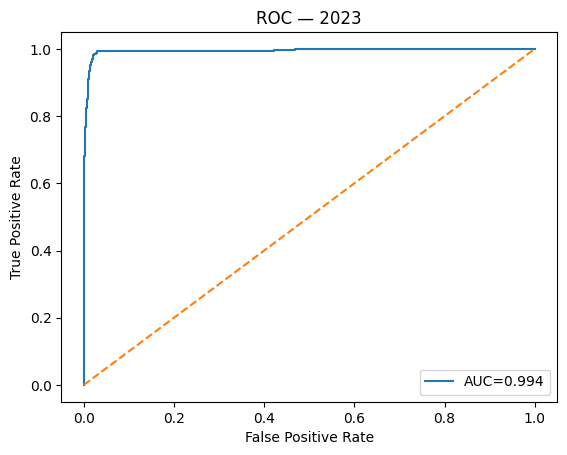

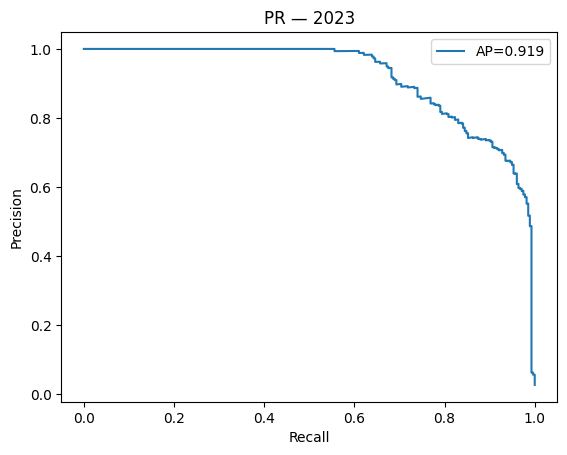


Top-15 features by permutation importance (AP):
                    feature  importance
22                 a1c_lag1    0.199089
64                 a1c_lag2    0.046333
40                 bmi_lag2    0.044352
23           a1c_roll3_mean    0.028966
4                  bmi_lag1    0.028110
65            a1c_roll3_std    0.020310
24           a1c_delta_prev    0.016555
67            a1c_roll3_max    0.011902
29           alt_roll3_mean    0.007044
6            bmi_delta_prev    0.006675
68                egfr_lag2    0.005233
25                egfr_lag1    0.004379
63  triglycerides_roll3_max    0.004368
72                 alt_lag2    0.003613
32           ast_roll3_mean    0.003399


In [3]:
# Load artifact (HGB): pipeline + feature_names + threshold + val_year
art   = joblib.load(ART_PATH)
pipe  = art["pipeline"]
feats = art["feature_names"]
tau   = float(art["threshold"])
val_y = int(art["val_year"])

# Load validation frame (Part 4)
dfv = read_partition_auto(Path(BASE_DIR) / DATASET_P4, val_y)
X   = dfv.reindex(columns=feats)              # maintain training feature order
y   = dfv["label_observed"].astype(int).values

# Predict
p = pipe.predict_proba(X)[:, 1]
yhat = (p >= tau).astype(int)

# ROC
fpr, tpr, _ = roc_curve(y, p)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC — {val_y}"); plt.legend(); plt.show()

# PR
prec, rec, thr = precision_recall_curve(y, p)
ap = average_precision_score(y, p)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR — {val_y}"); plt.legend(); plt.show()

# Permutation importance on the pipeline (scoring = average_precision)
warnings.filterwarnings("ignore")
perm = permutation_importance(pipe, X, y, scoring="average_precision",
                              n_repeats=5, random_state=42)
imp_df = (pd.DataFrame({"feature": feats, "importance": perm.importances_mean})
            .sort_values("importance", ascending=False))
print("\nTop-15 features by permutation importance (AP):")
print(imp_df.head(15))


## Slice analysis (+ lift), with label modes: observed / true / true_window

In [4]:
# Cell 3 — Slice analysis (observed / true / true_window) with duplicate handling + fallback

EVAL_LABEL_MODE = "observed"   # "observed" | "true" | "true_window"
SLICE_COLS      = ["sex", "ses_quintile", "region"]

from pathlib import Path

# Helpers (define if missing from earlier cells)
try:
    read_partition_auto
except NameError:
    def read_partition_auto(base_dir, year):
        base_dir = Path(base_dir)
        p = base_dir / f"year={year}"
        pq = p / "part-0.parquet"
        cs = p / "part-0.csv"
        if pq.exists(): return pd.read_parquet(pq)
        if cs.exists(): return pd.read_csv(cs)
        raise FileNotFoundError(f"Missing partition for year={year} under {p}")

try:
    list_years
except NameError:
    def list_years(base_dir):
        base = Path(base_dir)
        ys = [int(d.name.split("=")[1]) for d in base.iterdir() if d.is_dir() and d.name.startswith("year=")]
        ys.sort()
        return ys

# Reuse: pipe, feats, tau, val_y, BASE_DIR, DATASET_P4, DATASET_P3
p4_base = Path(BASE_DIR) / DATASET_P4
df_p4v  = read_partition_auto(p4_base, val_y)

# Try to source slice columns from P3 -> P2 -> P1
candidates = [
    ("patient_year_part3_nb", "P3"),
    ("patient_year_part2_nb", "P2"),
    ("patient_year_part1_nb", "P1"),
]

df_slice = None
slice_source = None
for ds_name, tag in candidates:
    ds_base = Path(BASE_DIR) / ds_name
    if not ds_base.exists():
        continue
    try:
        tmp = read_partition_auto(ds_base, val_y)
    except FileNotFoundError:
        continue
    present = [c for c in SLICE_COLS if c in tmp.columns]
    if present:
        df_slice = tmp[["patient_id","year"] + present].copy()
        slice_source = f"{tag} ({ds_name})"
        break

# Drop duplicate slice columns from Part 4 so Part 3/2/1 names survive the merge
if df_slice is not None:
    dups = [c for c in SLICE_COLS if c in df_p4v.columns]
    if dups:
        df_p4v = df_p4v.drop(columns=dups)

# Merge (or proceed without slices)
if df_slice is None:
    print("[warn] Could not find slice columns in Part3/2/1. Proceeding without slice breakdown.")
    dfv = df_p4v.copy()
    present_slice_cols = []
else:
    dfv = df_p4v.merge(df_slice, on=["patient_id","year"], how="left")
    present_slice_cols = [c for c in SLICE_COLS if c in dfv.columns]
    print(f"Slice columns present from {slice_source}: {present_slice_cols}")

# Build ground truth by mode
if EVAL_LABEL_MODE == "observed":
    y_true = dfv["label_observed"].astype(int).values
elif EVAL_LABEL_MODE == "true":
    if "label_true" not in dfv.columns:
        p3_base = Path(BASE_DIR) / "patient_year_part3_nb"
        df_p3v = read_partition_auto(p3_base, val_y)
        dfv = dfv.merge(df_p3v[["patient_id","year","label_true"]], on=["patient_id","year"], how="left")
    y_true = dfv["label_true"].fillna(0).astype(int).values
elif EVAL_LABEL_MODE == "true_window":
    p3_base = Path(BASE_DIR) / "patient_year_part3_nb"
    years_all = list_years(p3_base)
    df_p3_all = pd.concat([read_partition_auto(p3_base, y) for y in years_all], ignore_index=True)
    true_year_map = (df_p3_all.loc[df_p3_all["label_true"]==1, ["patient_id","year"]]
                     .drop_duplicates().set_index("patient_id")["year"].to_dict())
    y_true = np.array([
        1 if (ty := true_year_map.get(int(p), None)) is not None and abs(int(yy)-int(ty)) <= 1 else 0
        for p, yy in zip(dfv["patient_id"].values, dfv["year"].values)
    ])
else:
    raise ValueError("EVAL_LABEL_MODE must be 'observed' | 'true' | 'true_window'")

# Predict with pipeline
X_val = dfv.reindex(columns=feats)
proba = pipe.predict_proba(X_val)[:, 1]
y_hat = (proba >= tau).astype(int)

# Metrics helpers
def safe_auc(y, p):
    u = np.unique(y);  return float(roc_auc_score(y, p)) if u.size > 1 else None
def safe_ap(y, p):
    u = np.unique(y);  return float(average_precision_score(y, p)) if u.size > 1 else None
def row_metrics(y, p, yhat):
    return {
        "precision": float(precision_score(y, yhat, zero_division=0)),
        "recall":    float(recall_score(y, yhat, zero_division=0)),
        "f1":        float(f1_score(y, yhat, zero_division=0)),
        "auc_roc":   safe_auc(y, p),
        "auprc":     safe_ap(y, p),
        "n":         int(len(y)),
        "positives": int(np.sum(y)),
        "prevalence": float(np.mean(y)),
        "pred_pos":  int(np.sum(yhat)),
    }

# Global
global_row = row_metrics(y_true, proba, y_hat)
print(f"Validation year: {val_y} | label mode: {EVAL_LABEL_MODE} | τ={tau:.3f}")
print("Global metrics:", global_row)

# Slices
rows = []
for col in present_slice_cols:
    for val in sorted(dfv[col].dropna().unique()):
        m = (dfv[col] == val).values
        if m.sum() == 0:
            continue
        r = row_metrics(y_true[m], proba[m], y_hat[m])
        r.update({"slice_col": col, "slice_val": str(val)})
        rows.append(r)

# Always define slc to avoid NameError later
if rows:
    slc = pd.DataFrame(rows).sort_values(["slice_col","f1"], ascending=[True, False]).reset_index(drop=True)
    display(slc)
    out_csv = Path(BASE_DIR) / "artifacts_v1" / f"slice_metrics_{EVAL_LABEL_MODE}_{val_y}.csv"
    slc.to_csv(out_csv, index=False)
    print(f"\nSaved slice metrics → {out_csv}")
else:
    slc = pd.DataFrame(columns=[
        "slice_col","slice_val","n","positives","prevalence","pred_pos",
        "precision","recall","f1","auc_roc","auprc"
    ])
    print("[info] No slice rows were built.")


Slice columns present from P3 (patient_year_part3_nb): ['sex', 'ses_quintile', 'region']
Validation year: 2023 | label mode: observed | τ=0.440
Global metrics: {'precision': 0.8028169014084507, 'recall': 0.8231046931407943, 'f1': 0.8128342245989305, 'auc_roc': 0.9942007321209043, 'auprc': 0.9194796742501087, 'n': 10000, 'positives': 277, 'prevalence': 0.0277, 'pred_pos': 284}


,precision,recall,f1,auc_roc,auprc,n,positives,prevalence,pred_pos,slice_col,slice_val
0,0.857143,0.893617,0.875000,0.986787,0.933525,1968,47,0.023882,49,region,South
1,0.788136,0.861111,0.823009,0.997412,0.934413,3424,108,0.031542,118,region,Center
2,0.840909,0.804348,0.822222,0.997934,0.943473,1551,46,0.029658,44,region,Jerusalem
3,0.789474,0.750000,0.769231,0.997003,0.877640,1021,20,0.019589,19,region,Sharon
4,0.759259,0.732143,0.745455,0.989268,0.877969,2036,56,0.027505,54,region,North
5,0.840580,0.852941,0.846715,0.997705,0.947086,1997,68,0.034051,69,ses_quintile,3
6,0.850000,0.796875,0.822581,0.997411,0.940495,1953,64,0.032770,60,ses_quintile,1
7,0.764706,0.847826,0.804124,0.997148,0.911662,1967,46,0.023386,51,ses_quintile,4
8,0.836735,0.773585,0.803922,0.985363,0.880669,2140,53,0.024766,49,ses_quintile,5
9,0.709091,0.847826,0.772277,0.996803,0.899656,1943,46,0.023675,55,ses_quintile,2



Saved slice metrics → ../data/clinical_synth_v1/artifacts_v1/slice_metrics_observed_2023.csv


## Add lift columns & save

In [5]:
# Add lift columns (optional). Run after Cell 3 if 'slc' and 'global_row' exist.
try:
    slc  # check existence
    global_row
except NameError:
    raise RuntimeError("Please run the Slice Analysis cell first (it creates 'slc' and 'global_row').")

slc = slc.copy()
p_global = float(global_row["prevalence"])

# Lift vs slice prevalence
slc["lift_slice"]        = slc.apply(lambda r: (r["auprc"]/r["prevalence"]) if r["prevalence"]>0 else np.nan, axis=1)
slc["auprc_norm_slice"]  = (slc["auprc"] - slc["prevalence"]) / (1 - slc["prevalence"].clip(upper=0.999999))

# Lift vs global prevalence
slc["lift_global"]       = slc["auprc"] / p_global if p_global > 0 else np.nan
slc["auprc_norm_global"] = (slc["auprc"] - p_global) / (1 - p_global)

cols_order = [
    "slice_col","slice_val","n","positives","prevalence","pred_pos",
    "precision","recall","f1","auc_roc","auprc",
    "lift_slice","auprc_norm_slice","lift_global","auprc_norm_global"
]
slc = slc[cols_order]

display(slc.sort_values(["slice_col","lift_slice"], ascending=[True, False]))

out_csv2 = Path(BASE_DIR) / "artifacts_v1" / f"slice_metrics_with_lift_{EVAL_LABEL_MODE}_{val_y}.csv"
slc.to_csv(out_csv2, index=False)
print(f"Saved with lift → {out_csv2}  |  global prevalence baseline = {p_global:.4f}")


,slice_col,slice_val,n,positives,prevalence,pred_pos,precision,recall,f1,auc_roc,auprc,lift_slice,auprc_norm_slice,lift_global,auprc_norm_global
3,region,Sharon,1021,20,0.019589,19,0.789474,0.750000,0.769231,0.997003,0.877640,44.803540,0.875196,31.683767,0.874154
0,region,South,1968,47,0.023882,49,0.857143,0.893617,0.875000,0.986787,0.933525,39.088877,0.931899,33.701264,0.931631
4,region,North,2036,56,0.027505,54,0.759259,0.732143,0.745455,0.989268,0.877969,31.920459,0.874518,31.695646,0.874493
2,region,Jerusalem,1551,46,0.029658,44,0.840909,0.804348,0.822222,0.997934,0.943473,31.811451,0.941745,34.060400,0.941863
1,region,Center,3424,108,0.031542,118,0.788136,0.861111,0.823009,0.997412,0.934413,29.624357,0.932277,33.733326,0.932545
7,ses_quintile,4,1967,46,0.023386,51,0.764706,0.847826,0.804124,0.997148,0.911662,38.983465,0.909547,32.911990,0.909145
9,ses_quintile,2,1943,46,0.023675,55,0.709091,0.847826,0.772277,0.996803,0.899656,38.000706,0.897223,32.478572,0.896798
8,ses_quintile,5,2140,53,0.024766,49,0.836735,0.773585,0.803922,0.985363,0.880669,35.559099,0.877639,31.793115,0.877270
6,ses_quintile,1,1953,64,0.032770,60,0.850000,0.796875,0.822581,0.997411,0.940495,28.699782,0.938479,33.952875,0.938799
5,ses_quintile,3,1997,68,0.034051,69,0.840580,0.852941,0.846715,0.997705,0.947086,27.813680,0.945220,34.190821,0.945578


Saved with lift → ../data/clinical_synth_v1/artifacts_v1/slice_metrics_with_lift_observed_2023.csv  |  global prevalence baseline = 0.0277
